# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

training_variables = util.training_variables
columns = util.all_relevant_variables + ['B0_deltaE','B0_CMS2_weMbc','B0_CMS0_weDeltae']

Welcome to JupyROOT 6.26/14


In [2]:
# 4S Data vs MC, regions: q^2 < 3; 4.5<roeMbc<5.05; deltaE

# Load data files
MC_4S = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb_control/*.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

data_4S = uproot.concatenate([f'../../Samples/Data/e_channel/proc13_4S_control_quaxo_1.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

df_mc_4S = pd.DataFrame(MC_4S)
df_data_4S = pd.DataFrame(data_4S)

MVA_tight = 'sig_prob>0.6'
MVA_loose = 'sig_prob>0.4'
MVA_all = 'sig_prob>0'

In [13]:
for df in [df_mc_4S,df_data_4S,]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [18]:
df_mc_4S_MVA = util.apply_mva_bcs(df_mc_4S, training_variables, MVA_loose)
df_data_4S_MVA = util.apply_mva_bcs(df_data_4S, training_variables, MVA_loose)

In [6]:
columns_without_nan = df_data_4S_MVA.columns[~df_data_4S_MVA.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_mc_4S_MVA, 'e', template=False)
mpl=util.mpl(samples,df_data_4S_MVA)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 55449
bkg_TDFl 2317
bkg_fakeTracks 1296
bkg_continuum 3188
bkg_combinatorial 7705
bkg_singleBbkg 3728
bkg_other_TDTl 0
$D\tau\nu$ 1644
$D^\ast\tau\nu$ 1044
$D\ell\nu$ 26422
$D^\ast\ell\nu$ 19866
$D^{\ast\ast}\tau\nu$ 641
$D^{\ast\ast}\ell\nu$ 11481
$D\ell\nu$_gap 2686
bkg_other_signal 0


In [19]:
columns_without_nan = df_data_4S_MVA.columns[~df_data_4S_MVA.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_mc_4S_MVA, 'e', template=False)
mpl=util.mpl(samples,df_data_4S_MVA)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 29301
bkg_TDFl 1585
bkg_fakeTracks 726
bkg_continuum 1881
bkg_combinatorial 4800
bkg_singleBbkg 2555
bkg_other_TDTl 0
$D\tau\nu$ 1356
$D^\ast\tau\nu$ 844
$D\ell\nu$ 20648
$D^\ast\ell\nu$ 15313
$D^{\ast\ast}\tau\nu$ 474
$D^{\ast\ast}\ell\nu$ 8702
$D\ell\nu$_gap 1952
bkg_other_signal 0


In [3]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor.load("../../AutogluonModels/ag-20241122_055446")

pred = predictor.predict_proba(data=df_mc_4S)

pred = pred.rename(columns={0: 'fakeTracks_prob', 
                            1: 'fakeD_prob',
                            2: 'fakeL_prob',
                            3: 'continuum_prob',
                            4: 'combinatorial_prob',
                            5: 'singleBbkg_prob',
                            8: 'sig_prob'})
df_mc_4S_pred = pd.concat([df_mc_4S, pred], axis=1)

In [4]:
columns_without_nan = df_data_4S.columns[~df_data_4S.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_mc_4S_pred, 'e', template=False)
mpl=util.mpl(samples,df_data_4S)
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 3625601
bkg_TDFl 45775
bkg_fakeTracks 107691
bkg_continuum 112618
bkg_combinatorial 143844
bkg_singleBbkg 50165
bkg_other_TDTl 0
$D\tau\nu$ 2783
$D^\ast\tau\nu$ 1941
$D\ell\nu$ 63416
$D^\ast\ell\nu$ 50476
$D^{\ast\ast}\tau\nu$ 2014
$D^{\ast\ast}\ell\nu$ 38907
$D\ell\nu$_gap 16204
bkg_other_signal 0


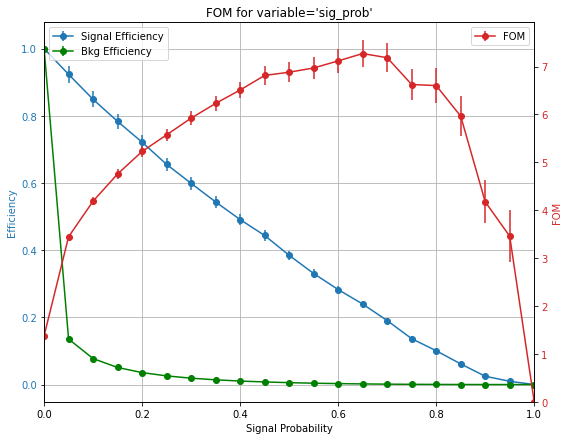

In [18]:
# ag-20241122_055446
tests = np.linspace(0,1,21)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_FakeD','bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='sig_prob', test_points=tests)

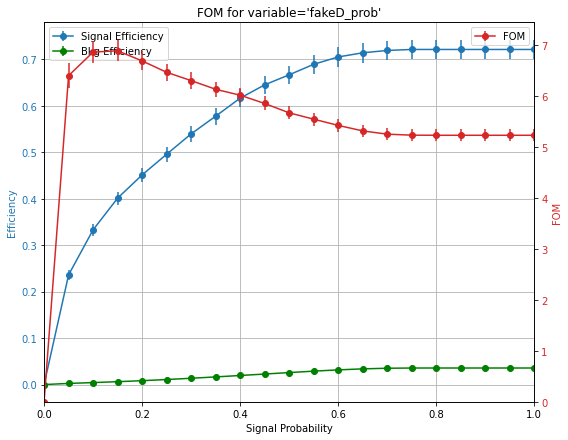

In [12]:
# ag-20241122_055446
tests = np.linspace(0,1,21)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_FakeD','bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='fakeD_prob', test_points=tests, cut='sig_prob>0.2',reverse=True)

In [ ]:
# ag-20241122_085044
tests = np.linspace(0,1,21)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_FakeD','bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='sig_prob', test_points=tests)

# BKG distribution at M_D signal region

/home/belle/zhangboy/inclusive_R_D/utilities.py:1032: RuntimeWarning: invalid value encountered in double_scalars
  label=f'rechi2 = {chi2:.3f} / {ndf} = {chi2/ndf:.3f}')


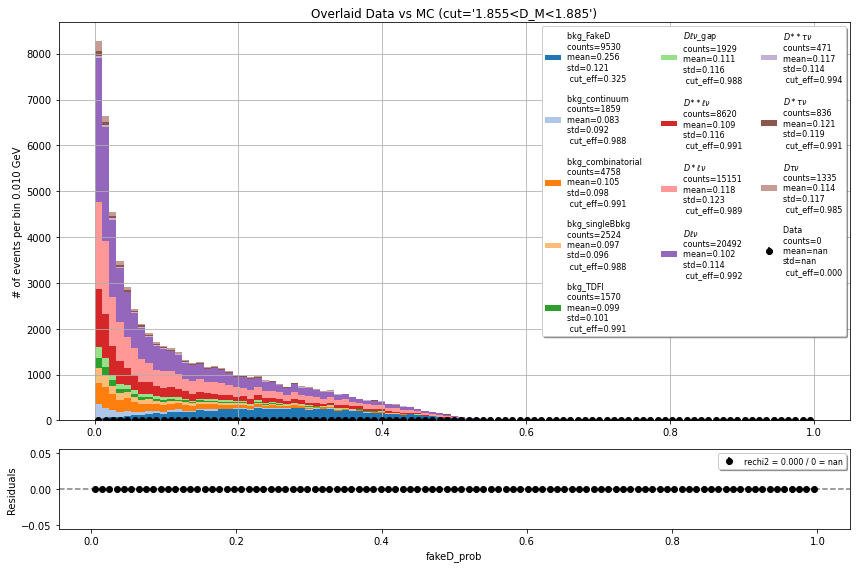

In [20]:
b1 = np.linspace(0,1,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='fakeD_prob',bins=b1,cut='1.855<D_M<1.885',scale=[1,187/200],
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=8)

/home/belle/zhangboy/inclusive_R_D/utilities.py:1032: RuntimeWarning: invalid value encountered in double_scalars
  label=f'rechi2 = {chi2:.3f} / {ndf} = {chi2/ndf:.3f}')


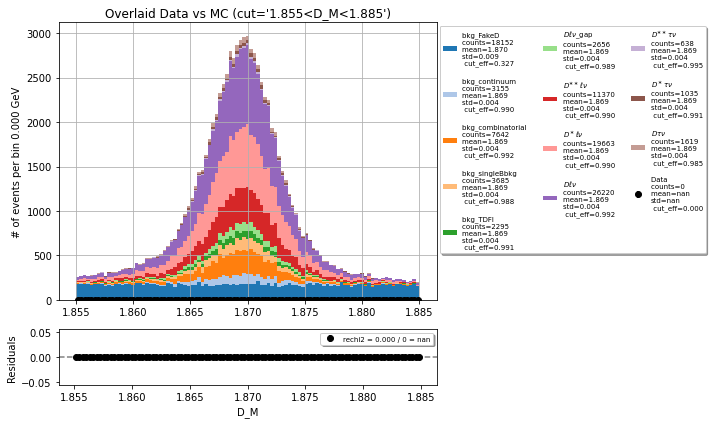

In [10]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.855,1.885,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut='1.855<D_M<1.885',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

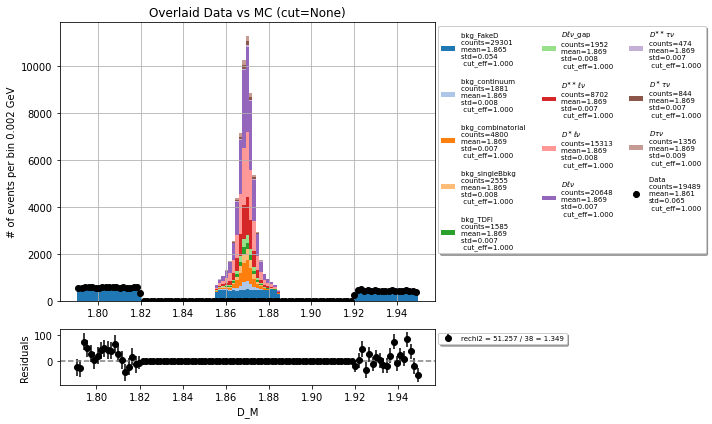

In [22]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut=None,scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

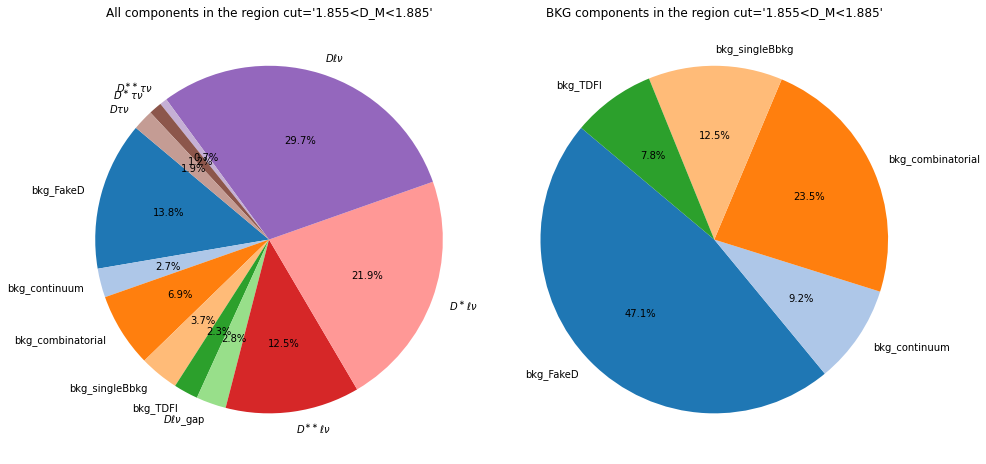

In [21]:
mpl.plot_pie()

# Create data driven template for FakeD
## 1. Calculate the sidebands to sig region scaling factors
### a. Histogram the D_M distribution

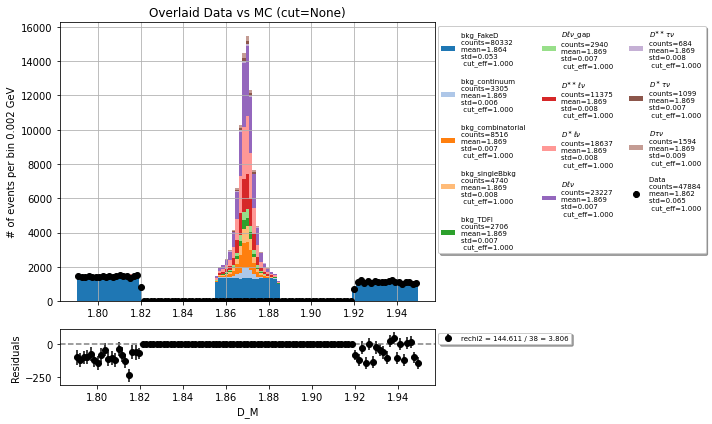

In [12]:
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,
                                                      scale=[1,187/200],correction=False,
                                                      data_sig_mask=True,
                                                      mask=[],figsize=(10,6),ratio=False,
                                                      legend_fs=7,legend_nc=3)

### b. fit the FakeD with a polynomial

In [13]:
fitter = util.fit_iminuit(x_edges=b1, hist=mc_hist_all, poly_only=True)

In [25]:
m_ls, c_ls, result_ls = fitter.fit_gauss_poly_LS(deg=1, loss='linear') #'soft_l1'
m_ls
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 2.9800e+01  1.8700e+00  4.0000e-02 -2.3808e+03  5.9571e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 41.56 (chi2/ndof = 1.2)    │              Nfcn = 69               │
│ EDM = 4.06e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    0.0    │    0.3    │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  40.0e-3  │  0.4e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │  -2.82e3  │  0.09e3   │            │            │         │         │       │
│ 4 │ x4   │  6.64e3   │  0.17e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0         0         0         0 │
│ x3 │         0         0         0  8.11e+03 -1.52e+04 │
│ x4 │         0         0         0 -1.52e+04  2.87e+04 │
└────┴───────────────────────────────────────────────────┘

In [14]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 1.488100e+04  1.870000e+00  4.000000e-02  1.488099e+05 -2.380800e+03
  5.953200e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.83 (chi2/ndof = 1.2)    │              Nfcn = 114              │
│ EDM = 3.67e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     0     │  0.15e3   │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  40.0e-3  │  0.4e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │  135.3e3  │   0.6e3   │            │            │         │         │       │
│ 4 │ x4   │  -2.6e3   │   0.5e3   │            │            │         │         │       │
│ 5 │ x5   │   6.0e3   │   1.2e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0         0 │
│ x1 │         0         0         0         0         0         0 │
│ x2 │         0         0         0         0         0         0 │
│ x3 │         0         0         0  3.72e+05      4.13     -9.73 │
│ x4 │         0         0         0      4.13  2.71e+05 -6.36e+05 │
│ x5 │         0         0         0     -9.73 -6.36e+05   1.5e+06 │
└────┴─────────────────────────────────────────────────────────────┘

### c. Calculate the yield ratio

In [15]:
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

Yields from 1.79 to 1.82: 28774.074
Yields from 1.855 to 1.885: 25366.664
Yields from 1.92 to 1.95: 21959.255


In [16]:
a = len(samples['bkg_FakeD'].query('1.79<D_M<1.82')) * 187/200
b = len(samples['bkg_FakeD'].query('1.92<D_M<1.95')) * 187/200
print('truth',a,b, a/b)

truth 28302.45 21887.415 1.2930924003588364


### d. Plot and compare MC of the weighted sideband and signal region

UnboundLocalError: local variable 'counts_err' referenced before assignment

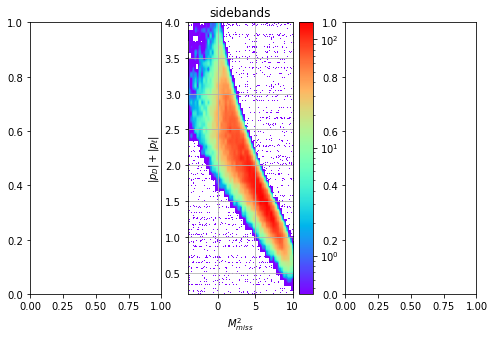

In [20]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable=['B0_CMS3_weMissM2','p_D_l'],
                        bins=[b1,b2],
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[],figsize=(16,5))

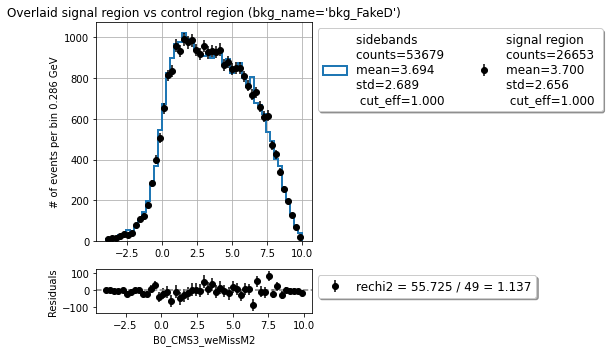

In [29]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[])

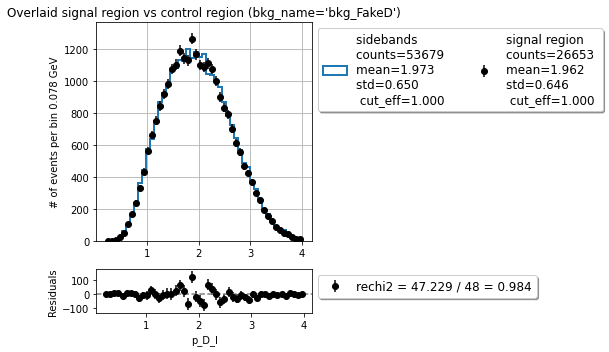

In [30]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut=None,
                        scale=scale,correction=False,mask=[])

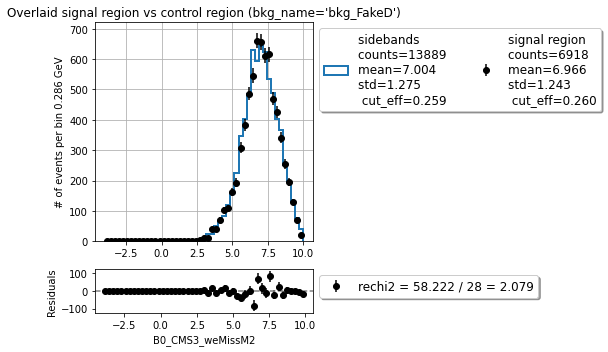

In [11]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut='p_D_l<1.5',merge_sidebands=True,
                        scale=scale,correction=False,mask=[])

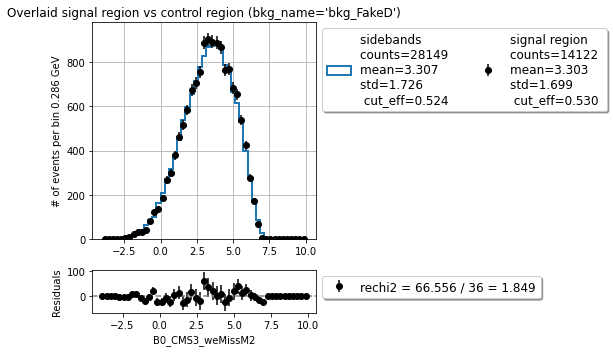

In [12]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut='1.5<p_D_l<2.5',merge_sidebands=True,
                        scale=scale,correction=False,mask=[])

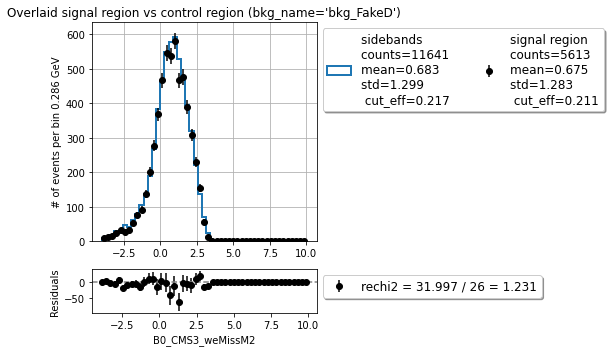

In [13]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut='2.5<p_D_l',merge_sidebands=True,
                        scale=scale,correction=False,mask=[])

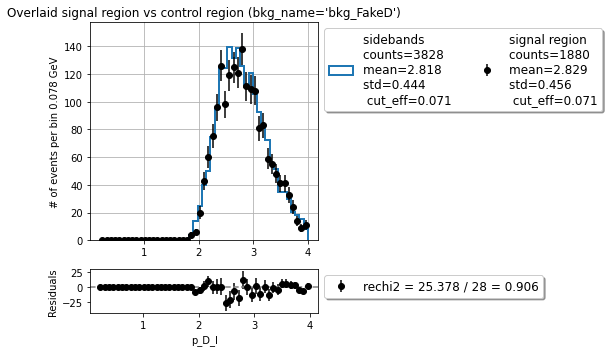

In [14]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut='B0_CMS3_weMissM2<0',
                        scale=scale,correction=False,mask=[])

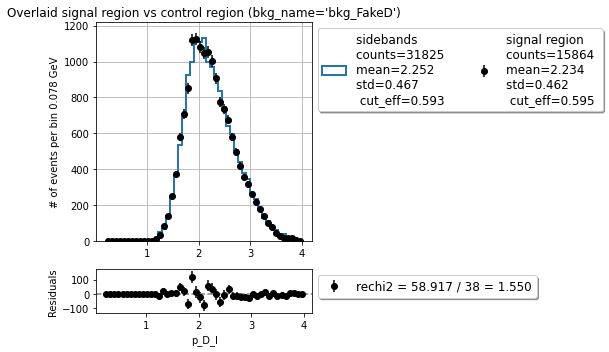

In [15]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut='0<B0_CMS3_weMissM2<5',
                        scale=scale,correction=False,mask=[])

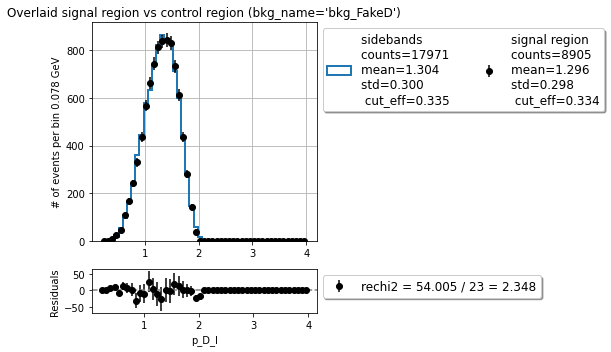

In [16]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut='5<B0_CMS3_weMissM2<10',
                        scale=scale,correction=False,mask=[])

# Check Data vs. MC at M_D sidebands

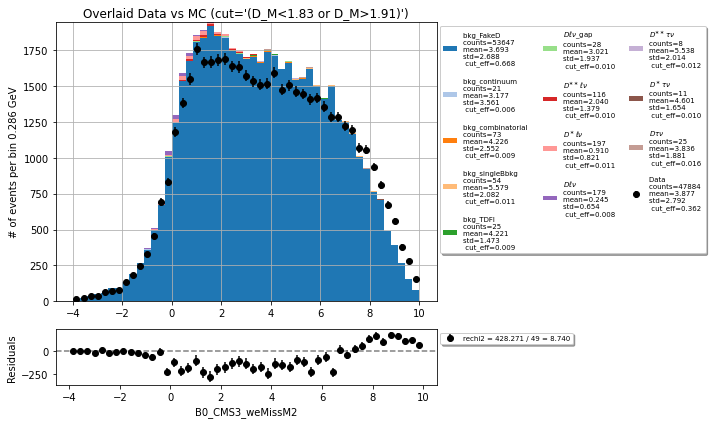

In [14]:
# sidebands
b1 = np.linspace(-4,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=False,mask=[],ratio=False,
                            legend_fs=7,legend_nc=3)

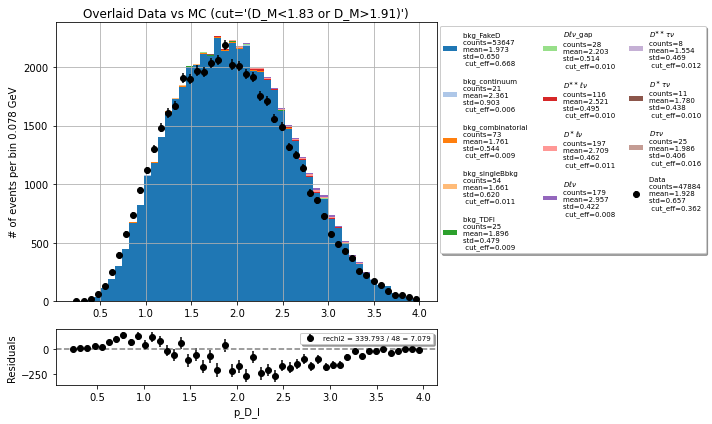

In [15]:
# sidebands
b2 = np.linspace(0.2,4,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6),
                            legend_fs=7,legend_nc=3)

## Other control regions

### 1. roeMbc<5

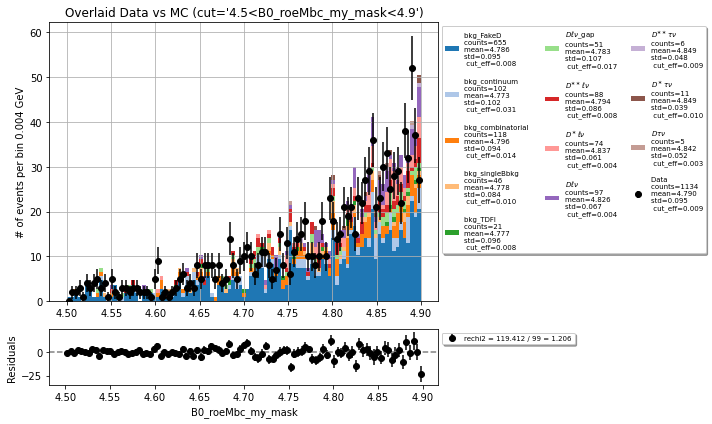

In [40]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(4.5,4.9,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_roeMbc_my_mask',bins=b1,cut='4.5<B0_roeMbc_my_mask<4.9',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

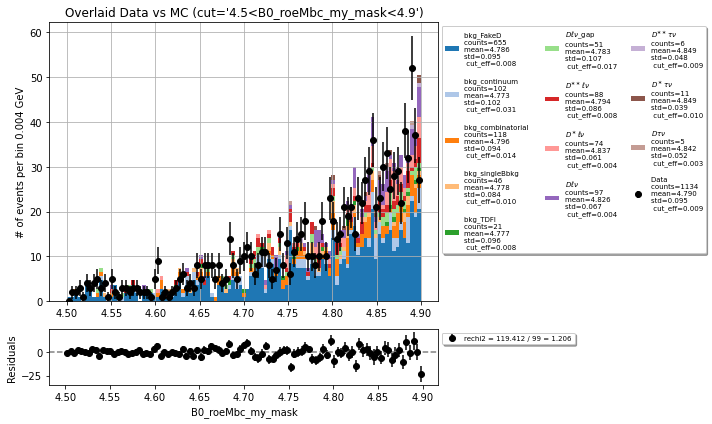

In [29]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(4.5,4.9,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_roeMbc_my_mask',bins=b1,cut='4.5<B0_roeMbc_my_mask<4.9',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

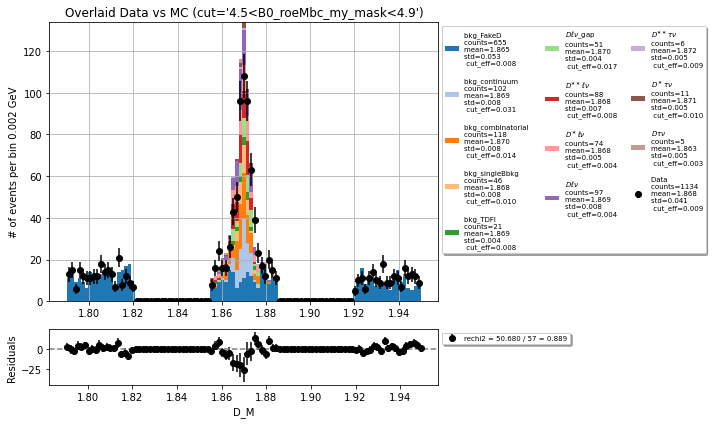

In [28]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut='4.5<B0_roeMbc_my_mask<4.9',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

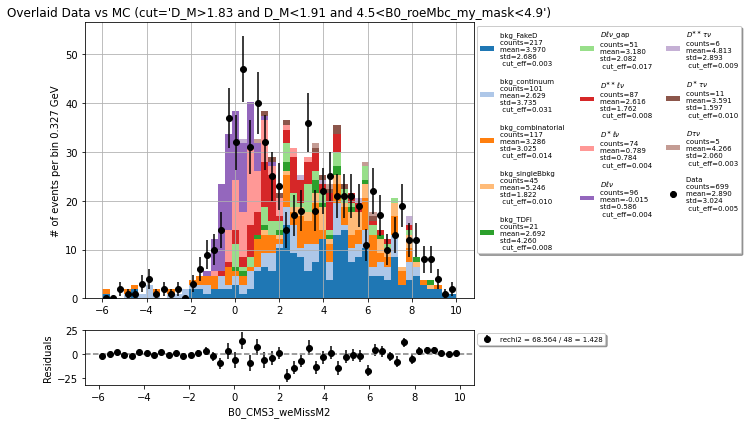

In [30]:
# signal
b1 = np.linspace(-6,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='D_M>1.83 and D_M<1.91 and 4.5<B0_roeMbc_my_mask<4.9',
                          scale=[1,187/200],correction=False,mask=[],ratio=False,
                                                      legend_nc=3, legend_fs=7)

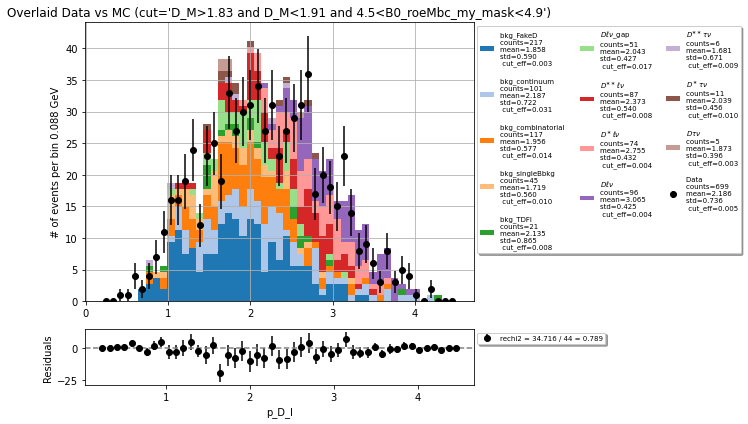

In [31]:
# signal
b2 = np.linspace(0.2,4.5,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='D_M>1.83 and D_M<1.91 and 4.5<B0_roeMbc_my_mask<4.9',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6),
                                                      legend_nc=3, legend_fs=7)

### 2. 4<CMS2_weMbc<4.5

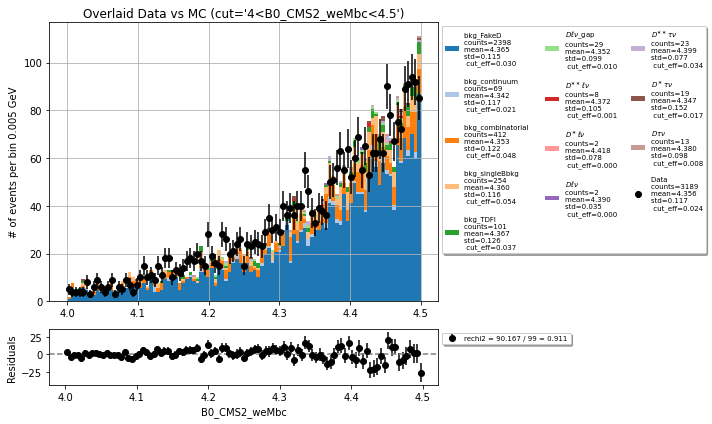

In [42]:
b1 = np.linspace(4,4.5,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS2_weMbc',bins=b1,cut='4<B0_CMS2_weMbc<4.5',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

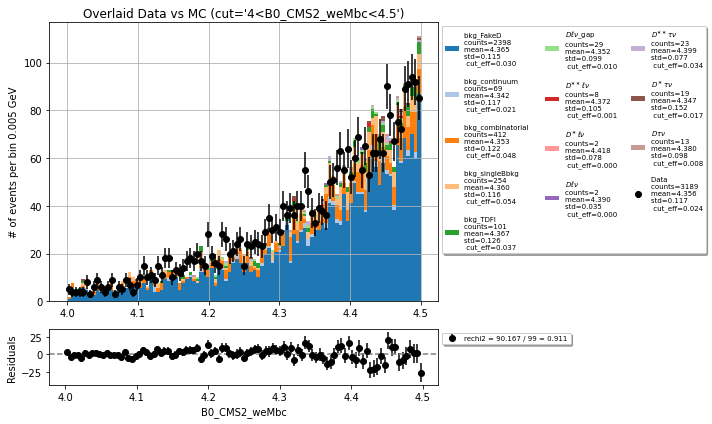

In [17]:
b1 = np.linspace(4,4.5,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS2_weMbc',bins=b1,cut='4<B0_CMS2_weMbc<4.5',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

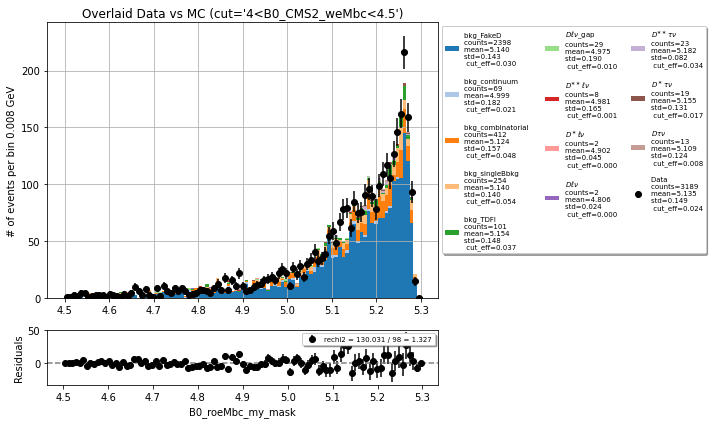

In [18]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(4.5,5.3,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_roeMbc_my_mask',bins=b1,cut='4<B0_CMS2_weMbc<4.5',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

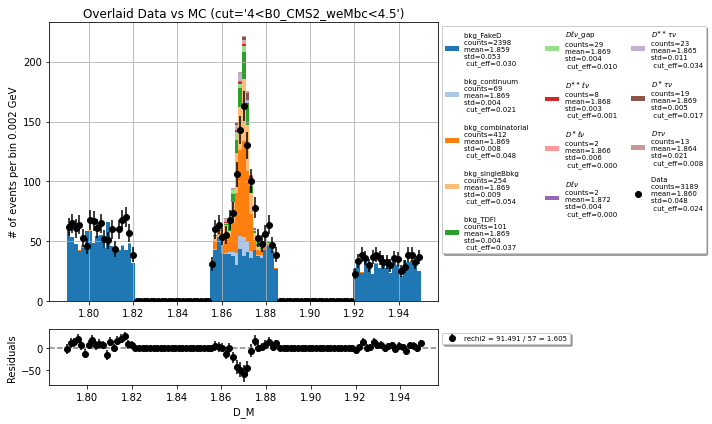

In [32]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut='4<B0_CMS2_weMbc<4.5',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

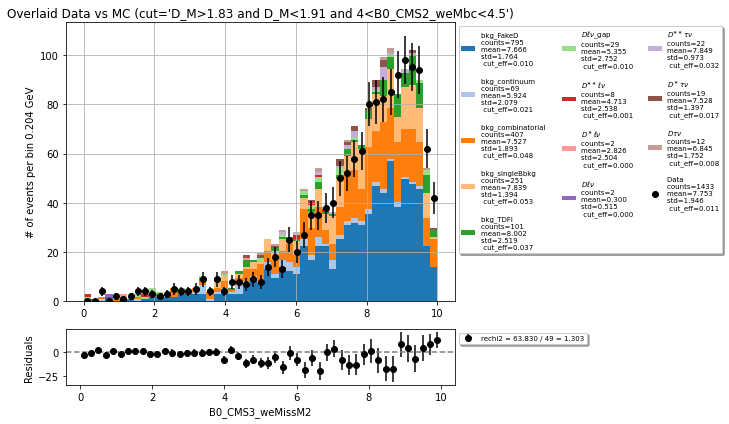

In [35]:
# signal
b1 = np.linspace(0,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='D_M>1.83 and D_M<1.91 and 4<B0_CMS2_weMbc<4.5',
                          scale=[1,187/200],correction=False,mask=[],ratio=False,
                                                      legend_nc=3, legend_fs=7)

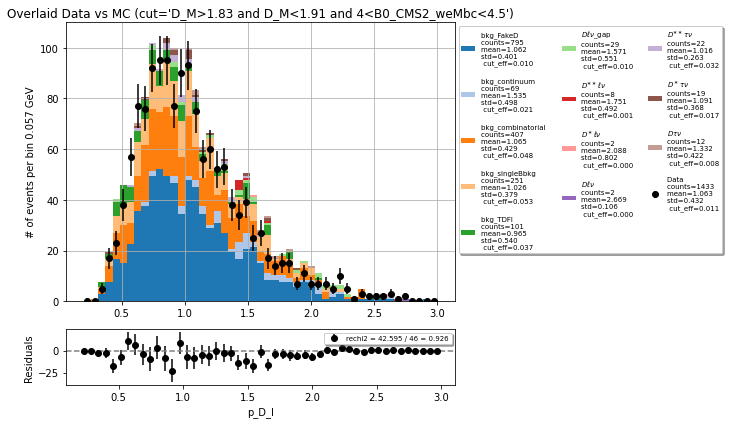

In [36]:
# signal
b2 = np.linspace(0.2,3,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='D_M>1.83 and D_M<1.91 and 4<B0_CMS2_weMbc<4.5',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6),
                                                      legend_nc=3, legend_fs=7)

### 3. q^2 < 3

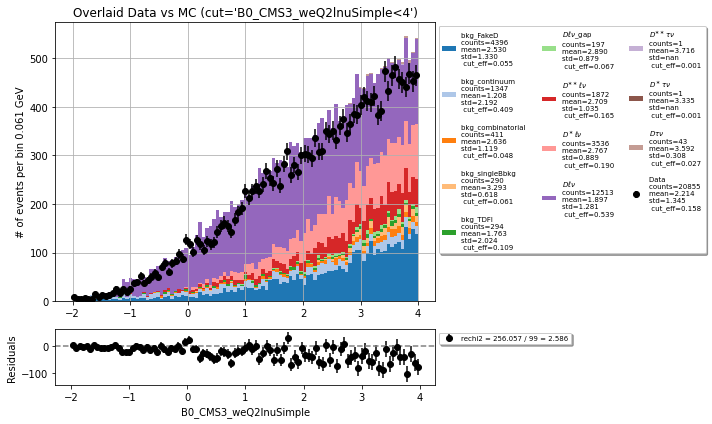

In [23]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(-2,4,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS3_weQ2lnuSimple',bins=b1,cut='B0_CMS3_weQ2lnuSimple<4',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

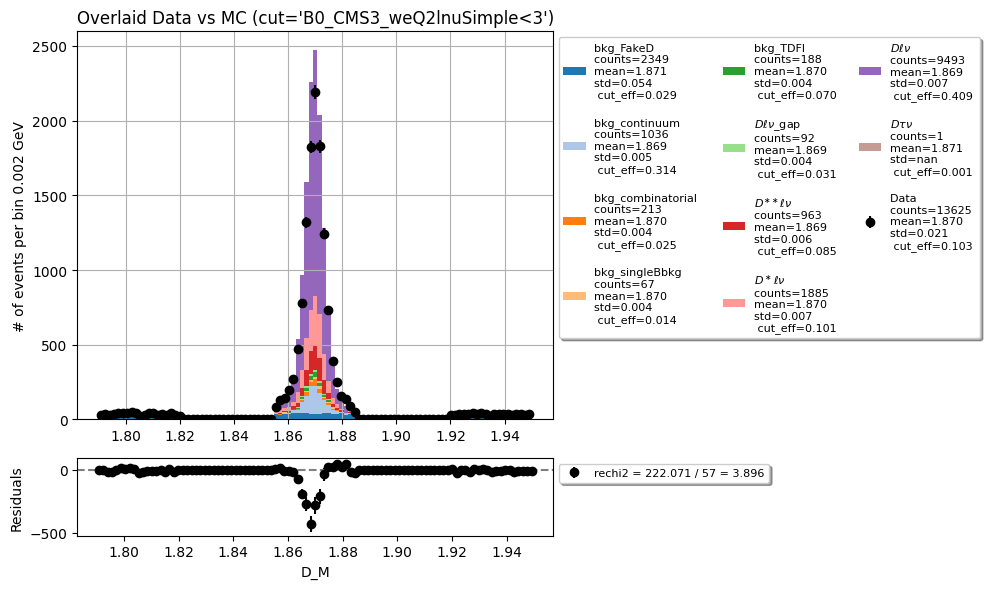

In [21]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut='B0_CMS3_weQ2lnuSimple<3',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=8)

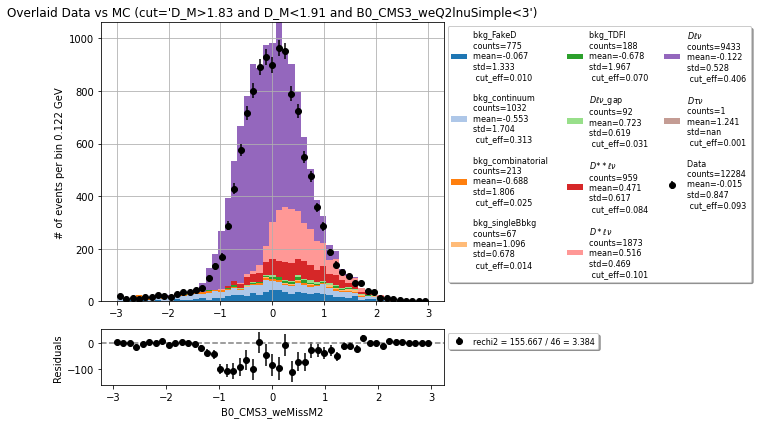

In [24]:
# signal
b1 = np.linspace(-3,3,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='D_M>1.83 and D_M<1.91 and B0_CMS3_weQ2lnuSimple<3',
                          scale=[1,187/200],correction=False,mask=[],ratio=False,
                                                      legend_nc=3, legend_fs=8)

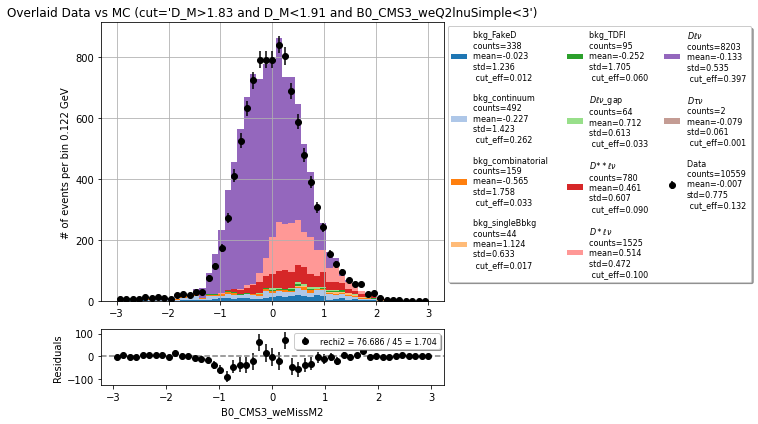

In [23]:
# signal
b1 = np.linspace(-3,3,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='D_M>1.83 and D_M<1.91 and B0_CMS3_weQ2lnuSimple<3',
                          scale=[1,187/200],correction=False,mask=[],ratio=False,
                                                      legend_nc=3, legend_fs=8)

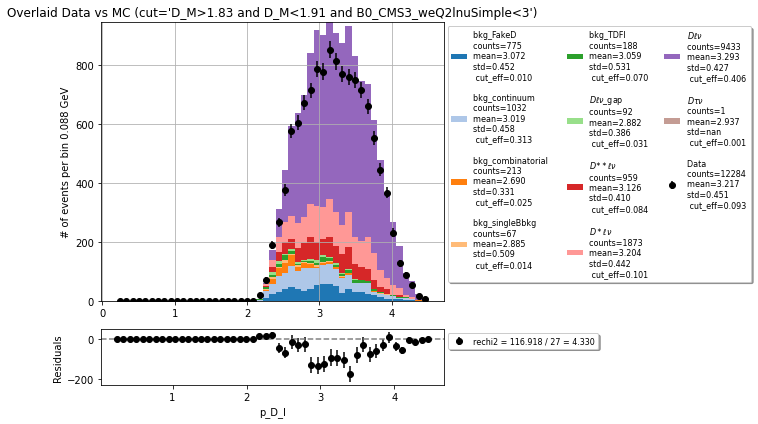

In [37]:
# signal
b2 = np.linspace(0.2,4.5,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='D_M>1.83 and D_M<1.91 and B0_CMS3_weQ2lnuSimple<3',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6),
                                                      legend_nc=3, legend_fs=8)

### 4. -1 < deltaE < 0

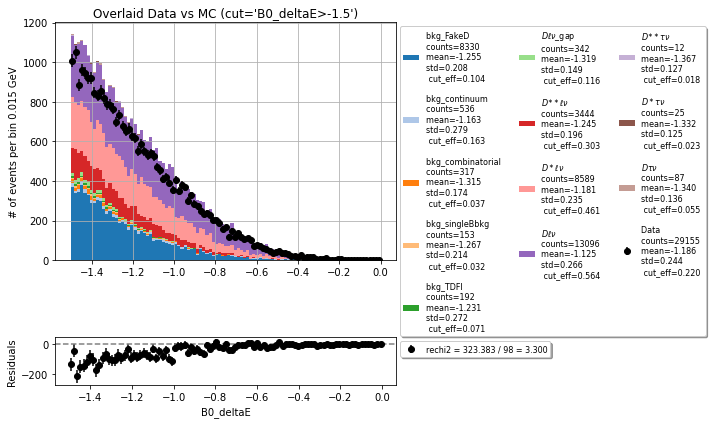

In [8]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(-1.5,0,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_deltaE',bins=b1,cut='B0_deltaE>-1.5',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=8)

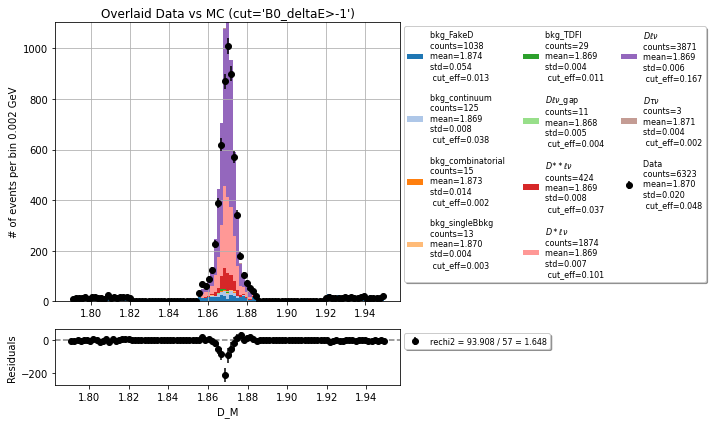

In [20]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut='B0_deltaE>-1',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=8)

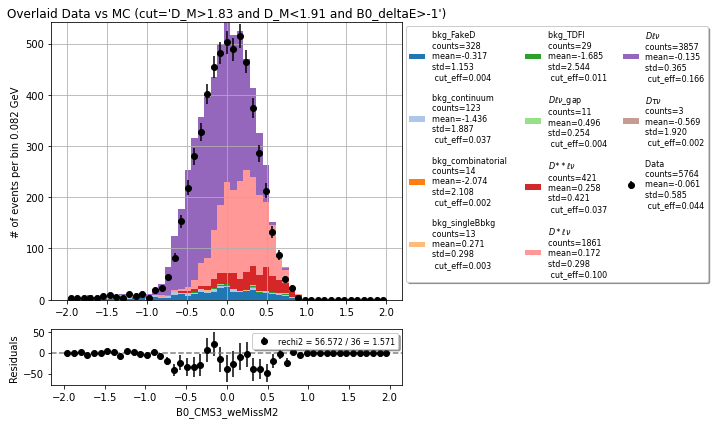

In [41]:
# signal
b1 = np.linspace(-2,2,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='D_M>1.83 and D_M<1.91 and B0_deltaE>-1',
                          scale=[1,187/200],correction=False,mask=[],ratio=False,
                                                      legend_nc=3, legend_fs=8)

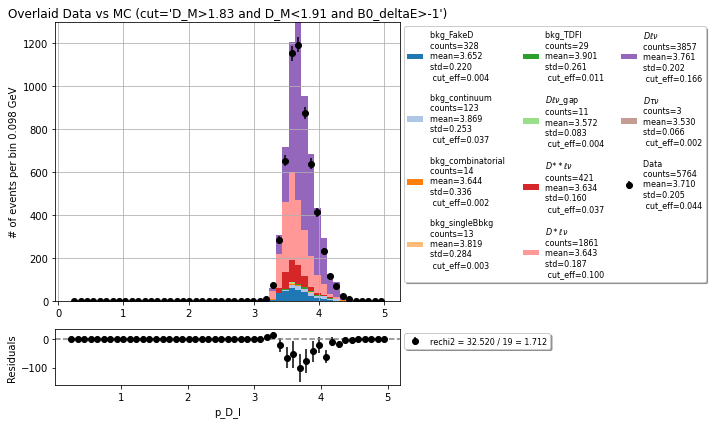

In [22]:
# signal
b2 = np.linspace(0.2,5,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='D_M>1.83 and D_M<1.91 and B0_deltaE>-1',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6),
                                                      legend_nc=3, legend_fs=8)

### 5. CMS0_weDeltae

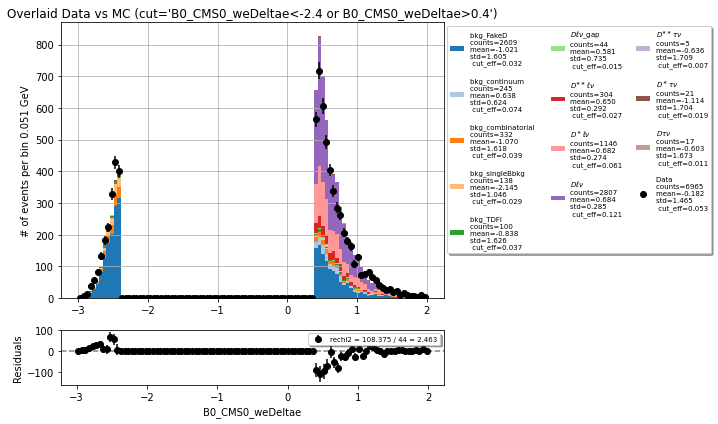

In [36]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(-3,2,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS0_weDeltae',bins=b1,cut='B0_CMS0_weDeltae<-2.4 or B0_CMS0_weDeltae>0.4',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

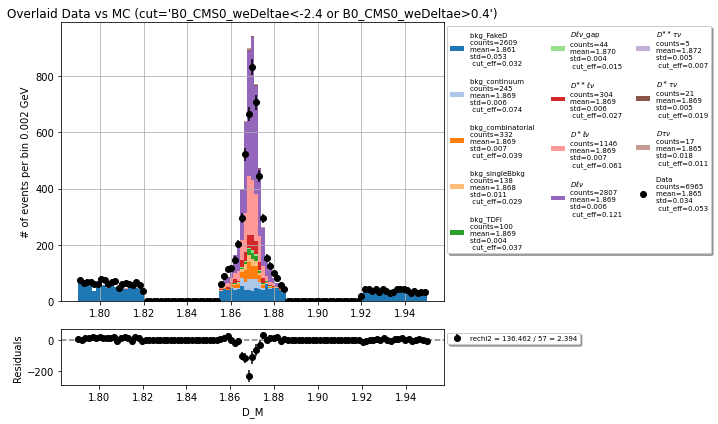

In [24]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut='B0_CMS0_weDeltae<-2.4 or B0_CMS0_weDeltae>0.4',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

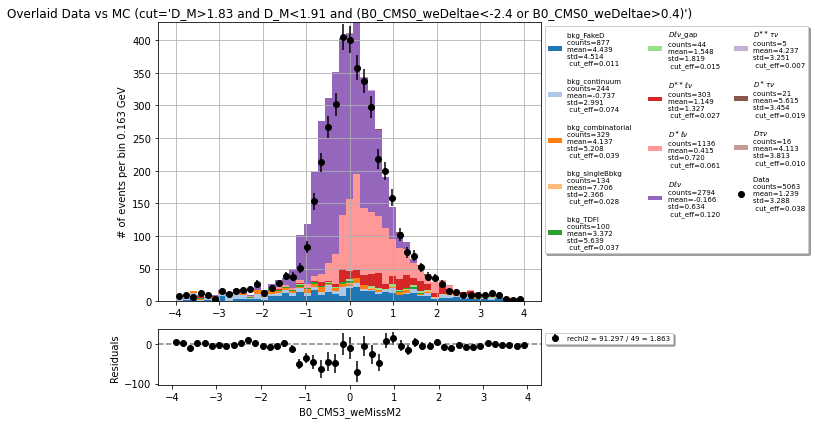

In [29]:
# signal
b1 = np.linspace(-4,4,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='D_M>1.83 and D_M<1.91 and (B0_CMS0_weDeltae<-2.4 or B0_CMS0_weDeltae>0.4)',
                          scale=[1,187/200],correction=False,mask=[],ratio=False,
                                                      legend_nc=3, legend_fs=7)

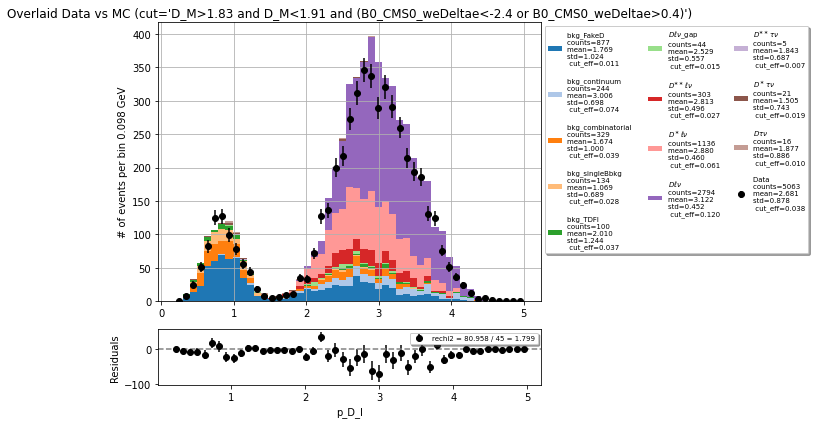

In [35]:
# signal
b2 = np.linspace(0.2,5,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='D_M>1.83 and D_M<1.91 and (B0_CMS0_weDeltae<-2.4 or B0_CMS0_weDeltae>0.4)',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6),
                                                      legend_nc=3, legend_fs=7)